## Final Project - SOLUTION

In this notebook, we build a ML model to predict the __Outcome Type__ field of our final project dataset.

1. <a href="#1">Read the dataset</a> (Given) 
2. <a href="#2">Train a model</a> (Implement)
    * <a href="#21">Exploratory Data Analysis</a>
    * <a href="#22">Select features to build the model</a>
    * <a href="#23">Data processing</a>
    * <a href="#24">Model training</a>
3. <a href="#3">Make predictions on the test dataset</a> (Implement)
4. <a href="#4">Evaluate accuracy</a> (Given)

__Austin Animal Center Dataset__:

In this exercise, we are working with pet adoption data from __Austin Animal Center__. We have two datasets that cover intake and outcome of animals. Intake data is available from [here](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm) and outcome is from [here](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238). 

In order to work with a single table, we joined the intake and outcome tables using the "Animal ID" column and created a training.csv, test_features.csv and y_test.csv files. Similar to our review dataset, we didn't consider animals with multiple entries to the facility to keep it simple. If you want to see the original datasets, they are available under `DATA/review` folder: Austin_Animal_Center_Intakes.csv, Austin_Animal_Center_Outcomes.csv.

__Dataset schema:__ 
- __Pet ID__ - Unique ID of pet
- __Outcome Type__ - State of pet at the time of recording the outcome
- __Sex upon Outcome__ - Sex of pet at outcome
- __Name__ - Name of pet 
- __Found Location__ - Found location of pet before entered the center
- __Intake Type__ - Circumstances bringing the pet to the center
- __Intake Condition__ - Health condition of pet when entered the center
- __Pet Type__ - Type of pet
- __Sex upon Intake__ - Sex of pet when entered the center
- __Breed__ - Breed of pet 
- __Color__ - Color of pet 
- __Age upon Intake Days__ - Age of pet when entered the center (days)
- __Time at Center__ - Time at center (0 = less than 30 days; 1 = more than 30 days). This is the value to predict. 


In [1]:
# #Upgrade dependencies
# !pip install --upgrade pip
# !pip install --upgrade scikit-learn

## 1. <a name="1">Read the datasets</a> (Given)
(<a href="#0">Go to top</a>)

Let's read the datasets into dataframes, using Pandas.

In [2]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")
  
training_data = pd.read_csv('../../DATA/final_project/training.csv')
test_data = pd.read_csv('../../DATA/final_project/test_features.csv')

print('The shape of the training dataset is:', training_data.shape)
print('The shape of the test dataset is:', test_data.shape)


The shape of the training dataset is: (71538, 13)
The shape of the test dataset is: (23846, 12)


## 2. <a name="2">Train a model</a> (Implement)
(<a href="#0">Go to top</a>)

 * <a href="#21">Exploratory Data Analysis</a>
 * <a href="#22">Select features to build the model</a>
 * <a href="#23">Data processing</a>
 * <a href="#24">Model training</a>

### 2.1 <a name="21">Exploratory Data Analysis</a> 
(<a href="#2">Go to Train a model</a>)

We look at number of rows, columns and some simple statistics of the dataset.

In [3]:
training_data.head(2)

,Pet ID,Outcome Type,Sex upon Outcome,Name,Found Location,Intake Type,Intake Condition,Pet Type,Sex upon Intake,Breed,Color,Age upon Intake Days,Time at Center
0,A745079,Transfer,Unknown,NaN,7920 Old Lockhart in Travis (TX),Stray,Normal,Cat,Unknown,Domestic Shorthair Mix,Blue,3,0
1,A801765,Transfer,Intact Female,NaN,5006 Table Top in Austin (TX),Stray,Normal,Cat,Intact Female,Domestic Shorthair,Brown Tabby/White,28,0


In [4]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71538 entries, 0 to 71537
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Pet ID                71538 non-null  object
 1   Outcome Type          71533 non-null  object
 2   Sex upon Outcome      71537 non-null  object
 3   Name                  44360 non-null  object
 4   Found Location        71538 non-null  object
 5   Intake Type           71538 non-null  object
 6   Intake Condition      71538 non-null  object
 7   Pet Type              71538 non-null  object
 8   Sex upon Intake       71537 non-null  object
 9   Breed                 71538 non-null  object
 10  Color                 71538 non-null  object
 11  Age upon Intake Days  71538 non-null  int64 
 12  Time at Center        71538 non-null  int64 
dtypes: int64(2), object(11)
memory usage: 7.1+ MB


Notice here that 'Name' has a lot of missing values. Let's go ahead and drop all rows where the name is missing. `subset` defines which column we want to consider for dropping, `axis` determines if the drop is row or column-wise and `inplace` refers to updating the dataframe directly (no need to re-assign it to a new variable).

In [5]:
training_data.dropna(subset = ['Name'], axis = 0, inplace = True)

#### Model features vs model target

In [6]:
# Split model target and features
model_target = 'Time at Center' # 0 & 1
model_features = training_data.columns.drop(model_target).tolist()

# Split model features between categorical and numerical features
categorical_features = training_data.select_dtypes(include='object').columns.tolist()
numerical_features = training_data.select_dtypes(include=np.number).columns.drop(model_target).tolist()

Plot histograms for all categorical features:

Pet ID


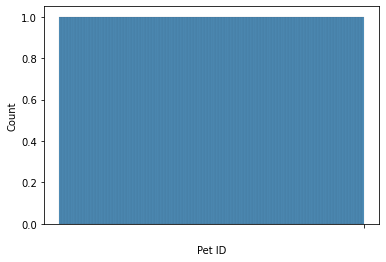

Outcome Type


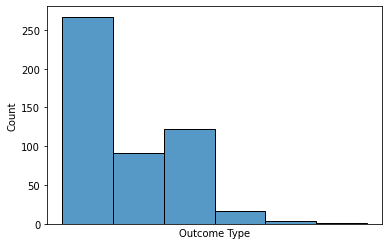

Sex upon Outcome


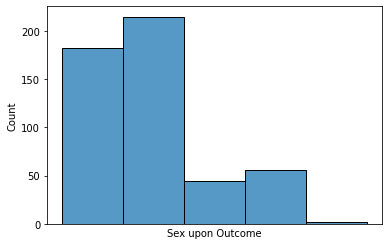

Name


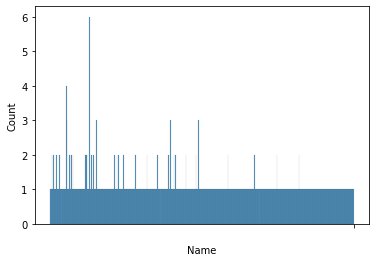

Found Location


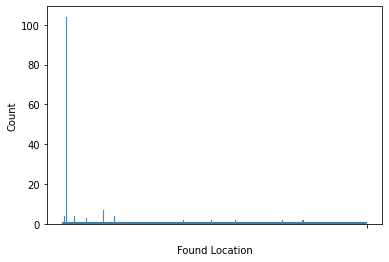

Intake Type


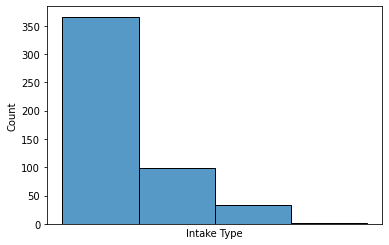

Intake Condition


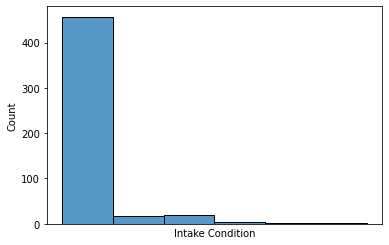

Pet Type


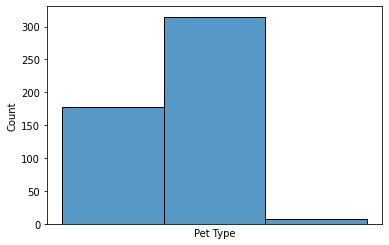

Sex upon Intake


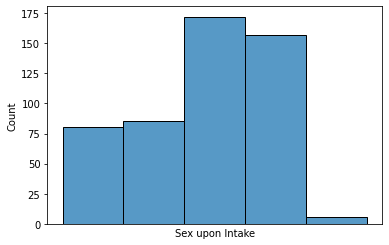

Breed


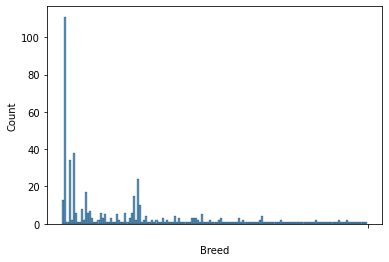

Color


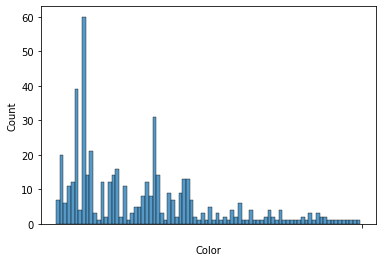

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (6,4))
for c in categorical_features:
    try:
        print(c)
        sns.histplot(training_data[str(c)].sample(500))
        plt.xticks(" ") # Stop python printing labels
        plt.show()
    except:
        print('Could not plot feature %s'%c)
        pass

#### Target Distribution

<AxesSubplot:>

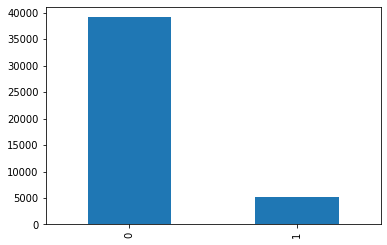

In [8]:
training_data[model_target].value_counts().plot.bar()

Upsample the underrepresented class:

In [9]:
print('Data set shape:', training_data.shape)

print('Class 0 samples in the data set:', sum(training_data[model_target] == 0))
print('Class 1 samples in the data set:', sum(training_data[model_target] == 1))

from sklearn.utils import shuffle

class_0_no = training_data[training_data[model_target] == 0]
class_1_no = training_data[training_data[model_target] == 1]

upsampled_class_1_no = class_1_no.sample(n=len(class_0_no), replace=True, random_state=42)

training_data_upsampled = pd.concat([class_0_no, upsampled_class_1_no])
training_data_upsampled = shuffle(training_data_upsampled)

print('Data set shape:', training_data_upsampled.shape)

print('Class 0 samples in the data set:', sum(training_data_upsampled[model_target] == 0))
print('Class 1 samples in the data set:', sum(training_data_upsampled[model_target] == 1))


Data set shape: (44360, 13)
Class 0 samples in the data set: 39137
Class 1 samples in the data set: 5223
Data set shape: (78274, 13)
Class 0 samples in the data set: 39137
Class 1 samples in the data set: 39137


#### Upsampled Data

<AxesSubplot:>

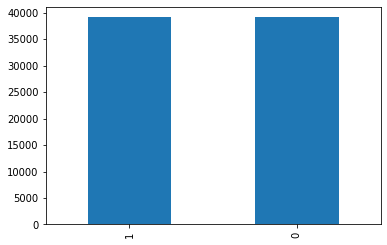

In [10]:
training_data_upsampled[model_target].value_counts().plot.bar()

### 2.2 <a name="22">Select features to build the model</a> 
(<a href="#2">Go to Train a model</a>)

Notice from EDA step that Pet ID, Name and Found Location are almost always unique and drop those columns from the features.

In [15]:
training_data_upsampled.drop(columns = ['Name', 'Pet ID', 'Found Location'], inplace = True)

In [13]:
categorical_features.remove('Name')
categorical_features.remove('Pet ID')
categorical_features.remove('Found Location')
categorical_features

['Outcome Type',
 'Sex upon Outcome',
 'Intake Type',
 'Intake Condition',
 'Pet Type',
 'Sex upon Intake',
 'Breed',
 'Color']

### 2.3 <a name="23">Data Processing</a> 
(<a href="#2">Go to Train a model</a>)


Try different scalers and imputers.

In [16]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


### COLUMN_TRANSFORMER ###
##########################

# Preprocess the numerical features
numerical_processor = Pipeline([
    ('num_imputer', SimpleImputer(strategy='mean')),
    ('num_scaler', StandardScaler()) # Shown in case is needed, not a must with Decision Trees
                                ])
                  
# Preprocess the categorical features
categorical_processor = Pipeline([
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='missing')), # Shown in case is needed, no effect here as we already imputed with 'nan' strings
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore')) # handle_unknown tells it to ignore (rather than throw an error for) any value that was not present in the initial training set.
                                ])

# Combine all data preprocessors from above (add more, if you choose to define more!)
# For each processor/step specify: a name, the actual process, and finally the features to be processed
numerical_data_preprocessor = ColumnTransformer([
    ('numerical_pre', numerical_processor, numerical_features)]) 

categorical_data_preprocessor = ColumnTransformer([
    ('categorical_pre', categorical_processor, categorical_features)]) 

data_preprocessor = ColumnTransformer([
    ('numerical_pre', numerical_processor, numerical_features),
    ('categorical_pre', categorical_processor, categorical_features)]) 


### 2.4 <a name="24">Model training/fitting</a> 
(<a href="#2">Go to Train a model</a>)

Suggestion to train three times: numerical only, categorical only, combined.

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


### PIPELINE ###
################

# Pipeline desired all data transformers, along with an estimator at the end
# Later you can set/reach the parameters using the names issued - for hyperparameter tuning, for example
numerical_pipeline = Pipeline([
    ('data_preprocessing', numerical_data_preprocessor),
    ('rf', RandomForestClassifier())
                    ])
categorical_pipeline = Pipeline([
    ('data_preprocessing', categorical_data_preprocessor),
    ('rf', RandomForestClassifier())
                    ])
pipeline = Pipeline([
    ('data_preprocessing', data_preprocessor),
    ('rf', RandomForestClassifier())
                    ])

X_train_numerical = training_data_upsampled[numerical_features]
X_train_categorical = training_data_upsampled[categorical_features]
X_train = training_data_upsampled[numerical_features + categorical_features]

# Labels always remain the same - independent of features
y_train = training_data_upsampled[model_target]


# Fit the Pipeline to training data
numerical_pipeline.fit(X_train_numerical, y_train)
categorical_pipeline.fit(X_train_categorical, y_train)
pipeline.fit(X_train, y_train);

In [24]:
# Visualize the pipeline
# This will come in handy especially when building more complex pipelines, stringing together multiple preprocessing steps
from sklearn import set_config
set_config(display='diagram')
numerical_pipeline

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age upon Intake Days'])])),
                ('rf', RandomForestClassifier())])

In [23]:
# Visualize the pipeline
# This will come in handy especially when building more complex pipelines, stringing together multiple preprocessing steps
from sklearn import set_config
set_config(display='diagram')
categorical_pipeline

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('categorical_pre',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Outcome Type',
                                                   'Sex upon Outcome',
                                                   'Intake Type',
                                                   'Intake Condition',
                                                   'Pet Type',
                                                   'Sex upon Intake', 'Breed',
                                                   'Color'])])),
                ('rf', RandomForestClassifier())])

In [25]:
# Visualize the pipeline
# This will come in handy especially when building more complex pipelines, stringing together multiple preprocessing steps
from sklearn import set_config
set_config(display='diagram')
pipeline

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age upon Intake Days']),
                                                 ('categorical_pre',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Outcome Type',
                                                   'Sex upon Outcome',
                                                   'Intake Type',
                                                   'Intake Condition',
                                                   'Pet Type',
                                                   'Sex upon Intake', 'Breed',
                                                   'Color'])])),
                ('rf', RandomForestClassifier())])

Let's look at [feature importance](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) for the model pipeline that contains only numerical features. In fact, there is only one numerical feature. The case for categorical features is non trivial as the pipeline itself applies OneHot encoding which explodes the number of features.

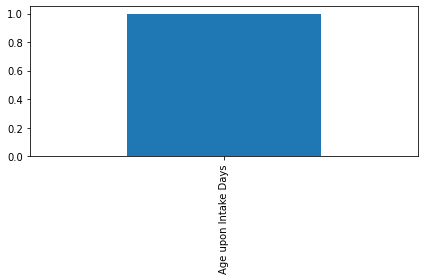

In [86]:
import pandas as pd

forest = numerical_pipeline.steps[1][1]
importances = forest.feature_importances_

std = np.std([
    forest.feature_importances_ for tree in forest.estimators_ ], axis=0)

forest_importances = pd.Series(importances, index = X_train_numerical.columns,)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
fig.tight_layout()

## 3. <a name="3">Make predictions on the test dataset</a> (Implement)
(<a href="#0">Go to top</a>)

Use the test set to make predictions with the trained model. *Beware*: The model here is called `classifier`; ensure to amend this as per model name used.

In [26]:
# Get test data to test the classifier
X_test = test_data
y_test = pd.read_csv('../../DATA/final_project/y_test.csv', header = None)

X_test_numerical = X_test[numerical_features]
X_test_categorical = X_test[categorical_features]
X_test = X_test[numerical_features + categorical_features]

# Use the fitted model to make predictions on the test dataset
num_test_predictions = numerical_pipeline.predict(X_test_numerical)
cat_test_predictions = categorical_pipeline.predict(X_test_categorical)
test_predictions = pipeline.predict(X_test)

## 4. <a name="4">Evaluate accuracy</a> (Given)
(<a href="#0">Go to top</a>)

Use the Sklearn in-built reports to evaluate model accuracy on training and test data.

In [89]:
print("Train accuracy for numerical features model:", accuracy_score(y_train, numerical_pipeline.predict(X_train_numerical)))
print("Train accuracy for categorical features model:", accuracy_score(y_train, categorical_pipeline.predict(X_train_categorical)))
print("Train accuracy:", accuracy_score(y_train, pipeline.predict(X_train)))

Train accuracy for numerical features model: 0.7735263305823135
Train accuracy for categorical features model: 0.9023302756981885
Train accuracy: 0.9659529345632011


In [27]:
print("Test accuracy for numerical features model:", accuracy_score(y_test, num_test_predictions))
print("Test accuracy for categorical features model:", accuracy_score(y_test, cat_test_predictions))
print("Test accuracy:", accuracy_score(y_test, test_predictions))

Test accuracy for numerical features model: 0.7670888199278705
Test accuracy for categorical features model: 0.8363666862366854
Test accuracy: 0.8964186865721714


We can tune our using GridSearch or RandomizedSearch. __WARNING: This will take a very long time to run ~ approx. 20 min.__

In [98]:
from sklearn.model_selection import GridSearchCV

# Parameter grid for GridSearch
param_grid={'rf__n_estimators': [20],# 100, 200, 300], 
            'rf__max_depth': [100, 200, 300],#, 50, 75, 100, 125, 150, 200, 250], 
            'rf__min_samples_leaf': [5, 10, 15],#, 25, 30],
            'rf__min_samples_split': [2, 5, 15]#, 25, 30, 45, 50]
           }

grid_search = GridSearchCV(pipeline, # Base model
                           param_grid, # Parameters to try
                           cv = 5, # Apply 5-fold cross validation
                           verbose = 1, # Print summary
                           n_jobs = -1 # Use all available processors
                          )

# Fit the GridSearch to our training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('data_preprocessing',
                                        ColumnTransformer(transformers=[('numerical_pre',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer()),
                                                                                         ('num_scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Age '
                                                                          'upon '
                                                                          'Intake '
                                                                          'Days']),
                                                                        ('categorical_pre',
                                                                         Pipeline(steps=[('cat_imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('cat_encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Outcome '
                                                                          'Type',
                                                                          'Sex '
                                                                          'upon '
                                                                          'Outcome',
                                                                          'Intake '
                                                                          'Type',
                                                                          'Intake '
                                                                          'Condition',
                                                                          'Pet '
                                                                          'Type',
                                                                          'Sex '
                                                                          'upon '
                                                                          'Intake',
                                                                          'Breed',
                                                                          'Color'])])),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [100, 200, 300],
                         'rf__min_samples_leaf': [5, 10, 15],
                         'rf__min_samples_split': [2, 5, 15],
                         'rf__n_estimators': [20]},
             verbose=1)

In [99]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'rf__max_depth': 100, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 2, 'rf__n_estimators': 20}
0.7851138764638714


In [100]:
from sklearn.model_selection import RandomizedSearchCV

# Parameter grid for GridSearch
param_grid={'rf__n_estimators': [20, 100, 200, 300], 
            'rf__max_depth': [100, 200, 300, 50, 75, 100, 125, 150, 200, 250], 
            'rf__min_samples_leaf': [5, 10, 15, 25, 30],
            'rf__min_samples_split': [2, 5, 15, 25, 30, 45, 50]
           }

rand_search = RandomizedSearchCV(pipeline, # Base model
                           param_grid, # Parameters to try
                           cv = 5, # Apply 5-fold cross validation
                           verbose = 1, # Print summary
                           n_jobs = -1 # Use all available processors
                          )
# Fit the GridSearch to our training data
rand_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('data_preprocessing',
                                              ColumnTransformer(transformers=[('numerical_pre',
                                                                               Pipeline(steps=[('num_imputer',
                                                                                                SimpleImputer()),
                                                                                               ('num_scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['Age '
                                                                                'upon '
                                                                                'Intake '
                                                                                'Days']),
                                                                              ('categorical_pre',
                                                                               Pipeline(steps=[('cat_imputer',
                                                                                                SimpleImputer(fill_value='missing',
                                                                                                              strategy='constant')),
                                                                                               ('cat_encoder...
                                                                                'Outcome',
                                                                                'Intake '
                                                                                'Type',
                                                                                'Intake '
                                                                                'Condition',
                                                                                'Pet '
                                                                                'Type',
                                                                                'Sex '
                                                                                'upon '
                                                                                'Intake',
                                                                                'Breed',
                                                                                'Color'])])),
                                             ('rf', RandomForestClassifier())]),
                   n_jobs=-1,
                   param_distributions={'rf__max_depth': [100, 200, 300, 50, 75,
                                                          100, 125, 150, 200,
                                                          250],
                                        'rf__min_samples_leaf': [5, 10, 15, 25,
                                                                 30],
                                        'rf__min_samples_split': [2, 5, 15, 25,
                                                                  30, 45, 50],
                                        'rf__n_estimators': [20, 100, 200,
                                                             300]},
                   verbose=1)

In [101]:
print(rand_search.best_params_)
print(rand_search.best_score_)

{'rf__n_estimators': 200, 'rf__min_samples_split': 50, 'rf__min_samples_leaf': 5, 'rf__max_depth': 75}
0.7823032499716298
